# Part 2

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Mario environment

In [24]:
class MarioEnv(gym.Env):
    def __init__(self):
        super(MarioEnv, self).__init__()
        self.grid_size = 5
        self.state = [(x, y) for x in range(self.grid_size) for y in range(self.grid_size)]
        self.action = spaces.Discrete(4)

        self.rewards = {state: -1 for state in self.state}
        self.rewards[(4, 4)] = 10
        self.rewards[(0, 2)] = -3
        self.rewards[(4, 1)] = -3
        self.rewards[(3, 3)] = 5
        self.wall = [(1, 1), (2, 4)]
        self.base = (0, 0)
        self.current = self.base

    def reset(self):
        return self.base

    def step(self, action):
        x, y = self.current
        if action == 0:
            x = max(x - 1, 0)
        elif action == 1:
            x = min(x + 1, self.grid_size - 1)
        elif action == 2:
            y = max(y - 1, 0)
        elif action == 3:
            y = min(y + 1, self.grid_size - 1)

        if (x, y) in self.wall:
            x, y = self.current

        self.current = (x, y)
        reward = self.rewards.get(self.current, -1)
        if self.current == (4, 4):
            goal = True
        else:
            goal = False

        return self.current, reward, goal

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xticks(np.arange(0, self.grid_size + 1, 1))
        ax.set_yticks(np.arange(0, self.grid_size + 1, 1))
        ax.grid(color="black")
        ax.set_aspect("equal")

        for (x, y), reward in self.rewards.items():
            color = "white"
            if reward == 10:
                color = "green"
            elif reward == -5:
                color = "red"
            elif reward == 5:
                color = "yellow"
            elif reward == -1:
                color = "gray"
            ax.add_patch(Rectangle((y, self.grid_size - 1 - x), 1, 1, color=color, alpha=0.5))

        for x, y in self.wall:
            ax.add_patch(Rectangle((y, self.grid_size - 1 - x), 1, 1, color="black", alpha=0.7))

        x_agent, y_agent = self.current
        ax.add_patch(Rectangle((y_agent, self.grid_size - 1 - x_agent), 1, 1, color="blue", alpha=0.7, label="Agent"))

        ax.legend(handles=[
            Rectangle((0, 0), 1, 1, color="green", alpha=0.5, label="Target"),
            Rectangle((0, 0), 1, 1, color="red", alpha=0.5, label="Penalty"),
            Rectangle((0, 0), 1, 1, color="yellow", alpha=0.5, label="Reward"),
            Rectangle((0, 0), 1, 1, color="black", alpha=0.7, label="Wall"),
            Rectangle((0, 0), 1, 1, color="blue", alpha=0.7, label="Agent")
        ], loc="upper right")

        plt.show()

## SARSA Agent

In [ ]:
class SARSAAgent:
    def __init__(self, env, lr=0.2, discount=0.99, exploration_rate=1.0, decay_rate=0.99, min_exploration_rate=0.1):
        self.env = env
        self.lr = lr
        self.discount = discount
        self.exploration_rate = exploration_rate
        self.decay_rate = decay_rate
        self.min_exploration_rate = min_exploration_rate
        self.q_table = defaultdict(lambda: np.zeros(env.action.n))
    
    def next_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return self.env.action.sample()
        return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state, next_action):
        target = reward + self.discount * self.q_table[next_state][next_action]
        error = target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * error

    def train(self, episodes=500, max_steps=100):
        rewards = []
        exploration_rate = []
        
        for episode in range(episodes):
            state = self.env.reset()
            action = self.next_action(state)
            total_reward = 0
            
            for _ in range(max_steps):
                next_state, reward, goal = self.env.step(action)
                next_action = self.next_action(next_state)
                self.update(state, action, reward, next_state, next_action)
                
                state, action = next_state, next_action
                total_reward += reward
                
                if goal:
                    break
            
            rewards.append(total_reward)
            exploration_rate.append(self.exploration_rate)
            
            self.exploration_rate = max(self.exploration_rate * self.decay_rate, self.min_exploration_rate)
        
        return rewards, exploration_rate

    def evaluate_greedy_policy(self, episodes=10, max_steps=100):
        rewards = []
        for _ in range(episodes):
            state = self.env.reset()
            total_reward = 0
            
            for _ in range(max_steps):
                action = np.argmax(self.q_table[state])
                state, reward, goal = self.env.step(action)
                total_reward += reward
                
                if goal:
                    break
            
            rewards.append(total_reward)
        
        return rewards

## Tuning and plot

In [26]:
env = MarioEnv()

def tuning(env, hyperparameter, values, other_params):
    results = {}
    for value in values:
        print(f"Training with {hyperparameter}={value}")
        params = {**other_params, hyperparameter: value}
        agent = SARSAAgent(env, **params)
        rewards, exploration_rate_values = agent.train(episodes=1000)
        greedy_rewards = agent.evaluate_greedy_policy(episodes=50)
        results[value] = {
            "agent": agent,
            "rewards": rewards,
            "exploration_rate_values": exploration_rate_values,
            "greedy_rewards": greedy_rewards,
        }
    return results

def plot(results, hyperparameter, title):
    plt.figure(figsize=(10, 5))
    for value, result in results.items():
        plt.plot(result["rewards"], label=f"{hyperparameter}={value}")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title(title)
    plt.legend()
    plt.show()

### Discount Rate Tuning

Training with discount=0.9
Training with discount=0.95
Training with discount=0.99


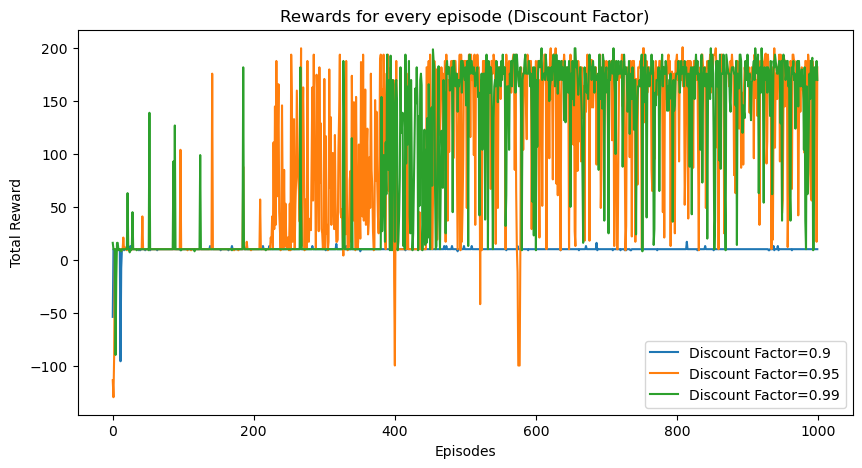

Best Discount Factor: 0.95


In [27]:
df_values = [0.9, 0.95, 0.99]
decay_rate = 0.95
params = { "lr": 0.2, "exploration_rate": 1.0, "decay_rate": decay_rate, "min_exploration_rate": 0.1}

discount_factor_result = tuning(env, "discount", df_values, params)

plt.figure(figsize=(10, 5))
for value, result in discount_factor_result.items():
    plt.plot(result["rewards"], label=f"{"Discount Factor"}={value}")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Rewards for every episode (Discount Factor)")
plt.legend()
plt.show()

best_discount_factor = max(discount_factor_result, key=lambda x: np.mean(discount_factor_result[x]["greedy_rewards"]))
print(f"Best Discount Factor: {best_discount_factor}")

### Decay rate tuning

Training with decay_rate=0.95
Training with decay_rate=0.99
Training with decay_rate=0.995


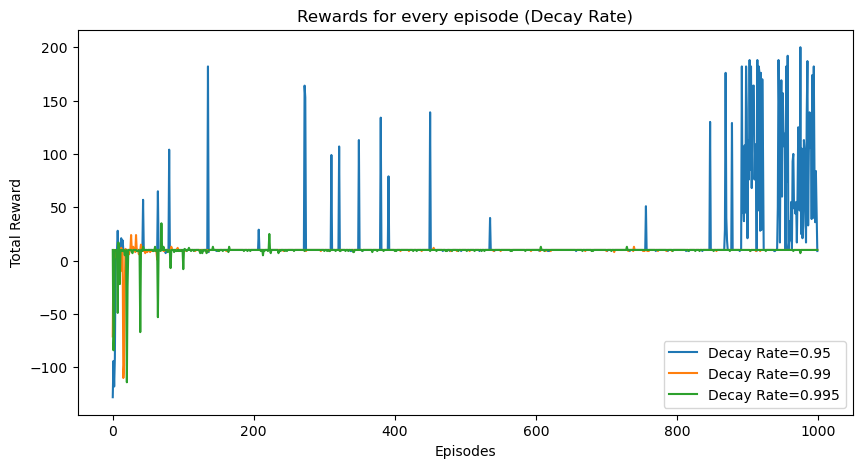

Best Decay Rate: 0.95


In [28]:
dr_values = [0.95, 0.99, 0.995]
discount_factor = 0.9
params_1 = {"lr": 0.2, "discount": discount_factor, "decay_rate": 1.0, "min_exploration_rate": 0.1}

decay_rate_results = tuning(env, "decay_rate", dr_values, params_1)

plt.figure(figsize=(10, 5))
for value, result in decay_rate_results.items():
    plt.plot(result["rewards"], label=f"{"Decay Rate"}={value}")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Rewards for every episode (Decay Rate)")
plt.legend()
plt.show()

best_decay_rate = max(decay_rate_results, key=lambda x: np.mean(decay_rate_results[x]["greedy_rewards"]))
print(f"Best Decay Rate: {best_decay_rate}")

## Training on best params

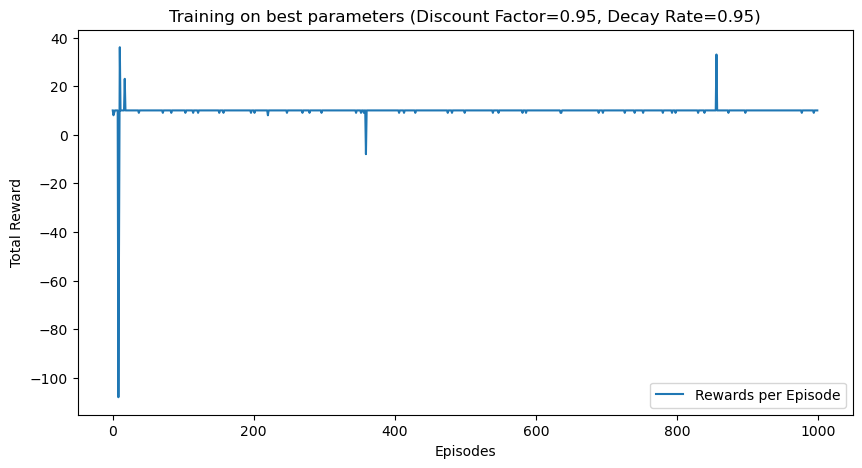

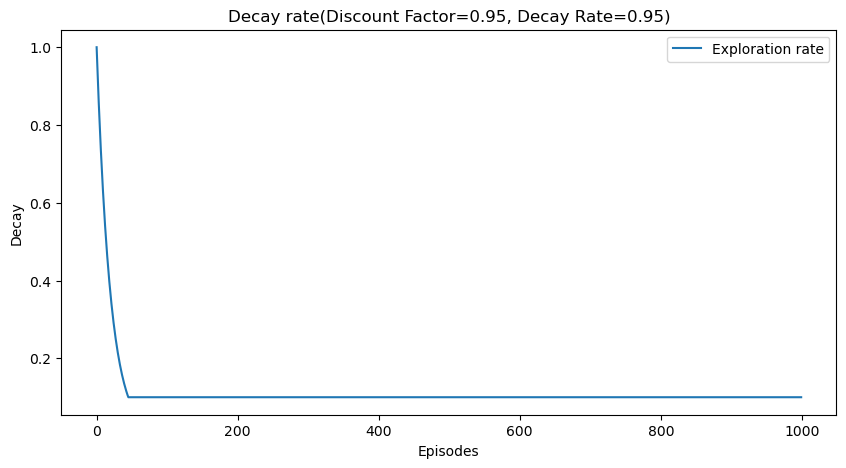

Greedy Policy rewards: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [29]:
params_best = {
    "lr": 0.2,
    "discount": best_discount_factor,
    "exploration_rate": 1.0,
    "decay_rate": best_decay_rate,
    "min_exploration_rate": 0.1
}

best_agent = SARSAAgent(env, **params_best)
best_rewards, best_exploration_rate = best_agent.train(episodes=1000)

best_greedy_rewards = best_agent.evaluate_greedy_policy(episodes=10)

plt.figure(figsize=(10, 5))
plt.plot(best_rewards, label="Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title(f"Training on best parameters (Discount Factor={best_discount_factor}, Decay Rate={best_decay_rate})")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(best_exploration_rate, label="Exploration rate")
plt.xlabel("Episodes")
plt.ylabel("Decay")
plt.title(f"Decay rate(Discount Factor={best_discount_factor}, Decay Rate={best_decay_rate})")
plt.legend()
plt.show()

print("Greedy Policy rewards:", best_greedy_rewards)


# References

https://www.geeksforgeeks.org/what-is-reinforcement-learning/

https://gymnasium.farama.org/introduction/train_agent/

https://www.geeksforgeeks.org/q-learning-in-python/

https://www.geeksforgeeks.org/sarsa-reinforcement-learning/

https://www.geeksforgeeks.org/reinforcement-learning-in-python-implementing-sarsa-agent-in-taxi-environment/

https://www.geeksforgeeks.org/how-to-visualize-and-interact-with-environments-in-reinforcement-learning/